In [1]:
import pandas as pd
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import warnings
warnings.filterwarnings('ignore')
from utils.data_proc import tab_data
from utils.data_proc import dataframe_column_adj
from utils.data_proc import load_data
from utils.data_proc import find_nearest



def recall_from_roc(x, threshold):
    filt_array = np.array(x['precision'])>threshold
    if sum(filt_array)>0:
        return max(np.array(x['recall'])[filt_array])
    else:
        return 0.
    
def energy_from_roc(x, threshold):
    filt_array = np.array(x['precision'])>threshold
    if sum(filt_array)>0:
        return (np.array(x['energy_after_threshold'])[filt_array]).max()
    else:
        return 0.

PATH = '../data/for_analysis/'

In [2]:
files = glob.glob(PATH + '*.json')

In [3]:
files

['../data/for_analysis/tv_wavelets.json',
 '../data/for_analysis/unet.json',
 '../data/for_analysis/energy_results_median_bm3d.json',
 '../data/for_analysis/energy_results_mean_gaussian_cygno.json',
 '../data/for_analysis/energy_results_wiener.json']

In [4]:
result_table = []
for file in files:
    result_table.append(tab_data(file))
result_table = pd.concat(result_table)

In [5]:
#result_table =  dataframe_column_adj(result_table)
result_table.parameter = result_table.parameter.apply(lambda x: 'none' if x == 0 else x)
result_table =  dataframe_column_adj(result_table)
# for i in result_table.parameter:
#     if(type(i)== int):
#         print(i)
#result_table =  dataframe_column_adj(result_table)
# #result_table['parameter'] == 'none'
# result_table['parameter'] = result_table.parameter.apply(lambda x: x[0])
# result_table.parameter

In [6]:
result_table.head()

,particle,energy,image,energia_ped,cluster_integral,filter,parameter,energy_after_threshold,recall,precision,threshold_all,f1
0,He,30,pic_run1_ev28,5069.65859,14878.0,tv,0,"[5070.4587238854365, 5070.4587238854365, 5068....","[0.99822695035461, 0.99822695035461, 0.9964539...","[0.37309476474486414, 0.4112490869247626, 0.44...","[6.967532691911069, 7.47452379119103, 7.981514...",0.878390
1,He,30,pic_run1_ev28,5069.65859,14878.0,tv,0,"[5070.4587238854365, 5070.4587238854365, 5065....","[0.99822695035461, 0.99822695035461, 0.9929078...","[0.3132999443516973, 0.3615928066795119, 0.405...","[5.255179576178049, 5.803111390168275, 6.35104...",0.867491
2,He,30,pic_run1_ev28,5069.65859,14878.0,tv,0,"[5070.4587238854365, 5067.950340722704, 5067.6...","[0.99822695035461, 0.9929078014184397, 0.98936...","[0.2769306443679292, 0.3389830508474576, 0.387...","[4.603215700387495, 5.172285794204093, 5.74135...",0.856146
3,He,30,pic_run1_ev28,5069.65859,14878.0,tv,0,"[5070.4587238854365, 5067.950340722704, 5067.3...","[0.99822695035461, 0.9929078014184397, 0.99113...","[0.19413793103448276, 0.25396825396825395, 0.3...","[3.564584058853683, 4.131771453955045, 4.69895...",0.852995
4,He,30,pic_run1_ev28,5069.65859,14878.0,tv,0,"[5070.4587238854365, 5067.350237377283, 5068.3...","[0.99822695035461, 0.9911347517730497, 0.98581...","[0.15556783641890023, 0.22368947579031612, 0.2...","[3.235243547037747, 3.804316825317689, 4.37339...",0.843610


In [7]:
result_table = result_table[result_table['filter'] != 'cygno']

In [8]:
files = glob.glob(PATH+'/cygno/' + '*.json')
result_table_cygno = []
for file in files:
    result_table_cygno.append(tab_data(file))
result_table_cygno = pd.concat(result_table_cygno)

result_table_cygno.parameter = result_table_cygno.parameter.apply(lambda x: 'none' if x == 0 else x)
result_table_cygno =  dataframe_column_adj(result_table_cygno)

In [9]:
result_table_cygno

,particle,energy,image,energia_ped,cluster_integral,filter,parameter,energy_after_threshold,recall,precision,threshold_all,f1
0,He,30,pic_run1_ev36,14930.161965,14880.0,cygno,0,"[14930.16196472018, 14930.16196472018, 14930.1...","[1.0, 1.0, 1.0, 1.0, 0.984070796460177, 0.8495...","[0.0001347064971923828, 0.0001347064971923828,...","[-6.78258162544941, -5.286050420742318, -3.789...",0.635266
1,He,30,pic_run1_ev21,14793.003287,14875.0,cygno,0,"[14793.00328670822, 14793.00328670822, 14793.0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.00013399124145507812, 0.0001339912414550781...","[-49.82908262953803, -47.967957149074124, -46....",0.631922
2,He,30,pic_run1_ev77,14959.329119,14909.0,cygno,0,"[14959.329119305667, 14959.329119305667, 14959...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.00013971328735351562, 0.0001397132873535156...","[-17.541883243705726, -16.163072938730533, -14...",0.642286
3,He,30,pic_run1_ev22,14846.051044,14941.0,cygno,0,"[14846.051043590352, 14846.051043590352, 14846...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.00013303756713867188, 0.0001330375671386718...","[-15.22225088418898, -13.771257010401637, -12....",0.639903
4,He,30,pic_run1_ev47,14914.120014,14945.0,cygno,0,"[14914.120014256467, 14914.120014256467, 14914...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0001308917999267578, 0.0001308917999267578,...","[-17.511342702475304, -16.00625181731829, -14....",0.652761
...,...,...,...,...,...,...,...,...,...,...,...,...
99,He,10,pic_run1_ev95,4811.543434,4951.0,cygno,0,"[4811.54343408318, 4811.54343408318, 4811.5434...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.00010514259338378906, 0.0001051425933837890...","[-39.52148447813386, -38.68283621010001, -37.8...",0.508523
100,He,10,pic_run1_ev28,4852.664000,4923.0,cygno,0,"[4852.664000430916, 4852.664000430916, 4852.66...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.00010657310485839844, 0.0001065731048583984...","[-16.585609608506445, -15.97299186507506, -15....",0.535073
101,He,10,pic_run1_ev37,4966.184712,4924.0,cygno,0,"[4966.184712300751, 4966.184712300751, 4966.18...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.00010395050048828125, 0.0001039505004882812...","[-9.390615615553088, -8.829639029651505, -8.26...",0.553191
102,He,10,pic_run1_ev14,5023.712575,4960.0,cygno,0,"[5023.71257480285, 5023.71257480285, 5023.7125...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.00010395050048828125, 0.0001039505004882812...","[-9.934776698624319, -9.371354779777331, -8.80...",0.528428


In [10]:
result_table = result_table.append(result_table_cygno, ignore_index=True)

In [11]:
best_filters = result_table.groupby(['particle', 'energy', 'image', 'filter']).agg({'f1':'max'}).reset_index()

[None, None]

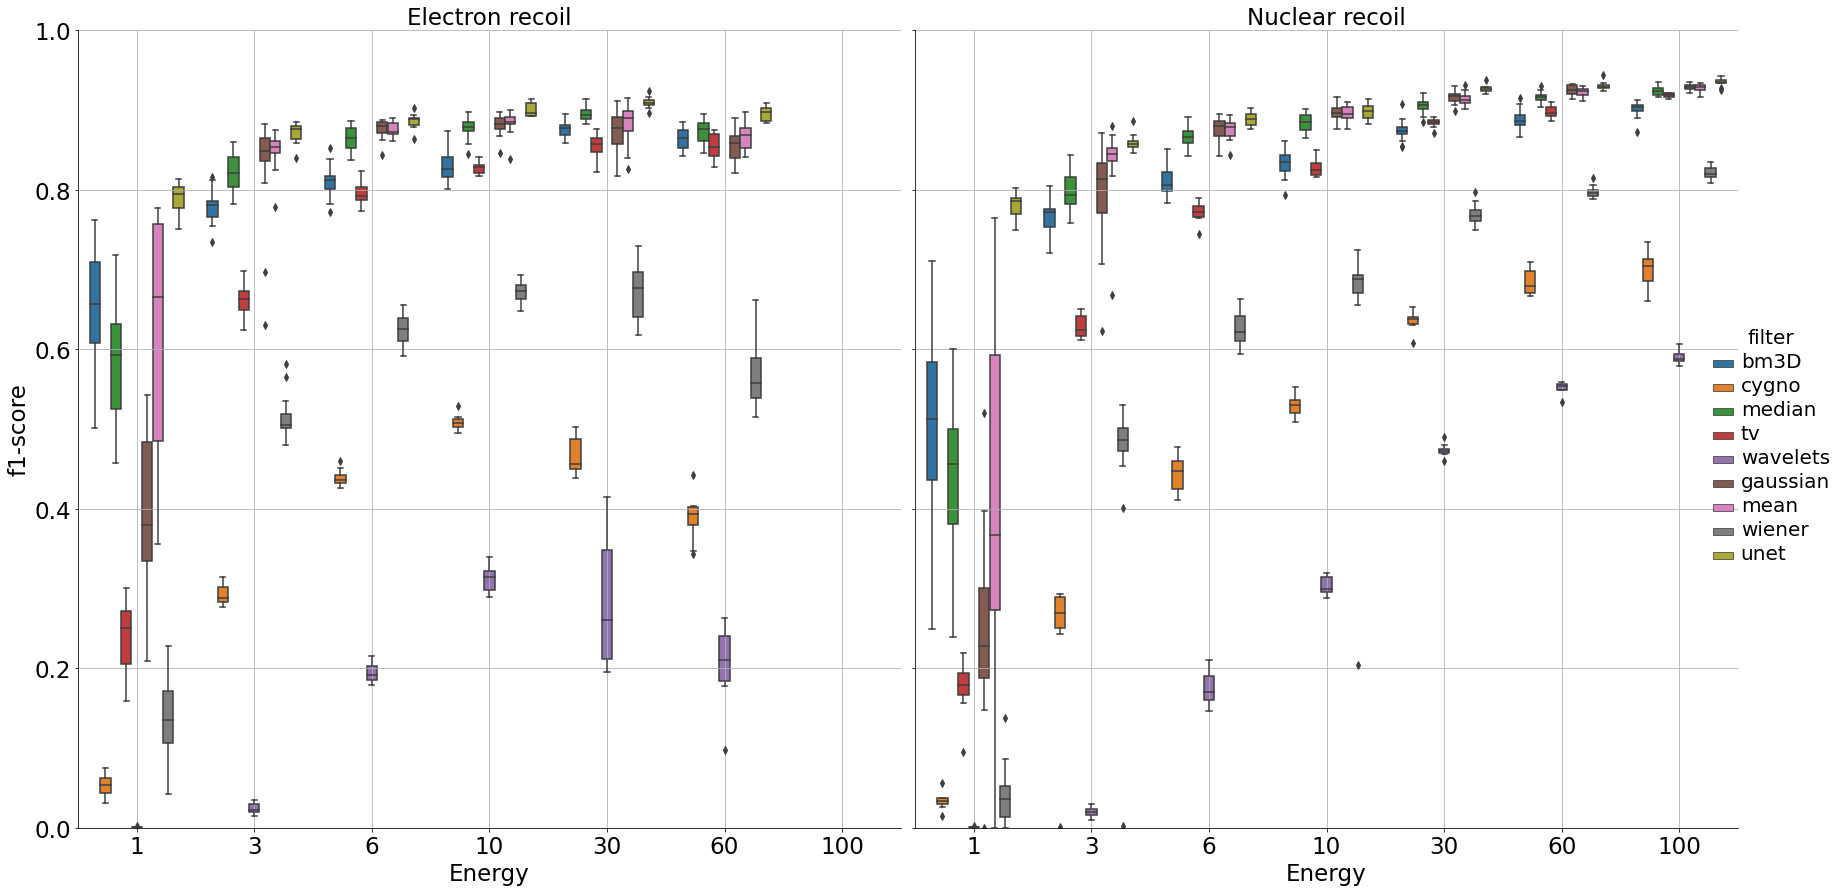

In [12]:
#plt.figure(figsize=(30,15))
g = sns.catplot(x="energy", y="f1", hue="filter", col="particle", data=best_filters, kind="box", height=12, aspect=1)
axes = g.axes.ravel()
axes[0].grid()
axes[1].grid()
axes[0].set_xlabel('Energy', fontsize=23)
axes[0].set_ylabel('f1-score', fontsize=23)
axes[1].set_xlabel('Energy', fontsize=23)
axes[0].tick_params(axis='both', which='major', labelsize=23)
axes[1].tick_params(axis='both', which='major', labelsize=23)
axes[0].set_ylim([0, 1])
axes[1].set_ylim([0, 1])
axes[0].set_title('Electron recoil', fontsize=23)
axes[1].set_title('Nuclear recoil', fontsize=23)

plt.setp(g._legend.get_texts(), fontsize=20)
plt.setp(g._legend.get_title(), fontsize=20)

In [13]:
threshold_precision = 0.90
result_table['recall_at_p'] = result_table.apply(lambda x: recall_from_roc(x, threshold_precision), axis=1)
result_table['energy_at_p'] = result_table.apply(lambda x: energy_from_roc(x, threshold_precision), axis=1)

In [14]:
energy_table = result_table.groupby(['particle', 'energy', 'image', 'filter']).agg({'f1':'max', 'recall_at_p': 'max', 'energy_at_p':'max', 'cluster_integral': 'max', 'energia_ped':'max'}).reset_index()

In [15]:
energy_table

,particle,energy,image,filter,f1,recall_at_p,energy_at_p,cluster_integral,energia_ped
0,ER,1,pic_run1_ev1,bm3D,0.655462,0.384977,284.869463,498.0,557.003767
1,ER,1,pic_run1_ev1,cygno,0.060837,0.014085,26.941765,498.0,593.819138
2,ER,1,pic_run1_ev1,median,0.569343,0.211268,176.003860,498.0,557.003767
3,ER,1,pic_run1_ev14,bm3D,0.640884,0.488789,373.403318,499.0,495.604244
4,ER,1,pic_run1_ev14,median,0.526946,0.313901,272.693068,499.0,495.604244
...,...,...,...,...,...,...,...,...,...
1729,He,100,pic_run1_ev95,mean,0.927110,0.939974,49826.166783,49896.0,49918.925583
1730,He,100,pic_run1_ev97,wiener,0.814875,0.710959,7156.490235,49920.0,7472.114393
1731,He,100,pic_run1_ev98,bm3D,0.894356,0.840483,49704.590128,49874.0,49821.610470
1732,He,100,pic_run1_ev98,median,0.929293,0.941019,49778.268393,49874.0,49821.610470


In [16]:
energy_table.columns = ['particle', 'energy', 'image', 'filter', 'f1', 'recall_p_value', 'recovered_energy', 'cluster_integral_truth', 'cluster_integral_after_ped']

In [17]:
data=pd.melt(energy_table[['energy', 'particle', 'cluster_integral_truth', 'cluster_integral_after_ped']], id_vars=['particle', 'energy'])
data

,particle,energy,variable,value
0,ER,1,cluster_integral_truth,498.000000
1,ER,1,cluster_integral_truth,498.000000
2,ER,1,cluster_integral_truth,498.000000
3,ER,1,cluster_integral_truth,499.000000
4,ER,1,cluster_integral_truth,499.000000
...,...,...,...,...
3463,He,100,cluster_integral_after_ped,49918.925583
3464,He,100,cluster_integral_after_ped,7472.114393
3465,He,100,cluster_integral_after_ped,49821.610470
3466,He,100,cluster_integral_after_ped,49821.610470


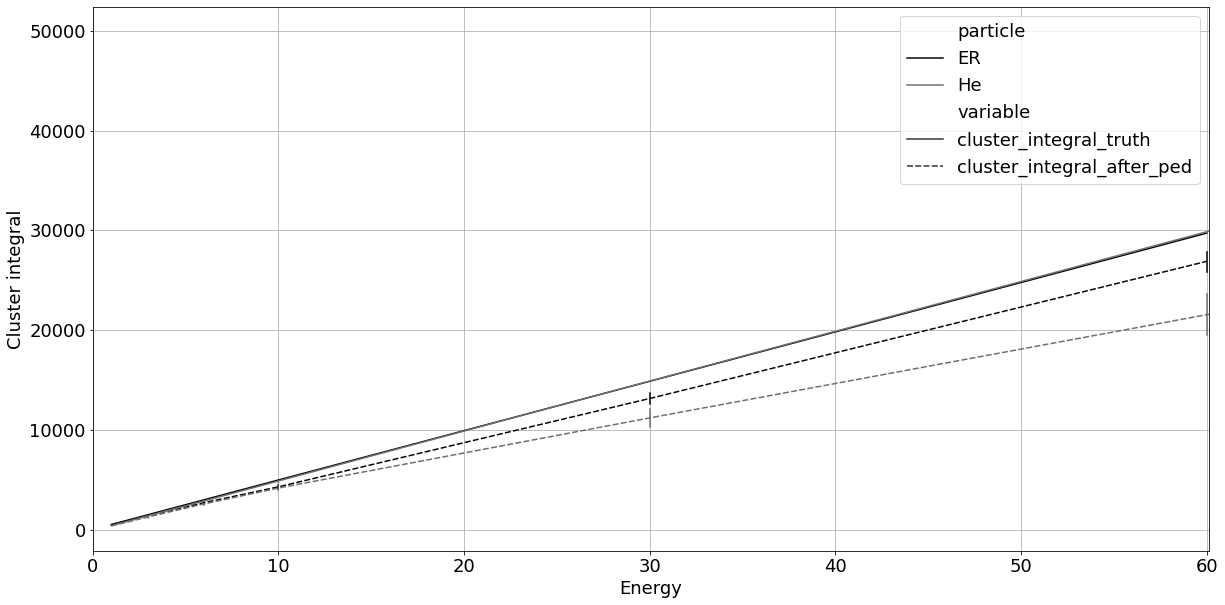

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
#palette = sns.color_palette("mako_r", 2)
# Create an array with the colors you want to use
colors = ["#040404", "#6F6F6F"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
sns.lineplot(x="energy", y="value", hue="particle", data=data,  err_style="bars", style="variable",  palette=customPalette, ax=axes)
axes.grid()
axes.set_ylabel('Cluster integral', fontsize=18)
axes.set_xlabel('Energy', fontsize=18)
axes.set_xlim([0, 60.1])
axes.tick_params(axis='both', which='major', labelsize=18)
axes.legend(fontsize=18)

In [19]:
energy_filter = energy_table[['energy', 'particle', 'filter', 'recovered_energy']]

In [20]:
energy_real = energy_table[['energy', 'particle', 'cluster_integral_after_ped']]
energy_real.columns = ['energy', 'particle', 'recovered_energy']
energy_real['filter'] = 'Energy after ped rem'

In [21]:
energy_filter = energy_filter.append(energy_real).reset_index(drop=True)

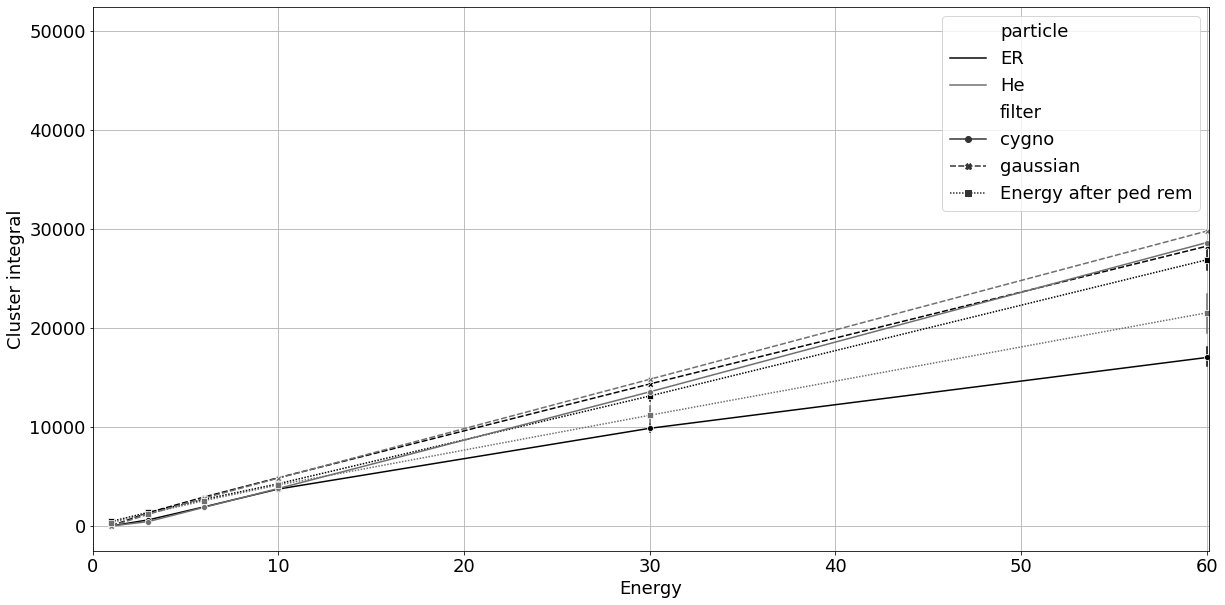

In [22]:
selec_filters = ['gaussian', 'Energy after ped rem', 'cygno']

# Create an array with the colors you want to use
colors = ["#040404", "#6F6F6F"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

fig, axes = plt.subplots(1, 1, figsize=(20, 10))
#palette = sns.color_palette("hls", 2)
ax = sns.lineplot(x="energy", y="recovered_energy", hue="particle", data=energy_filter[energy_filter['filter'].isin(selec_filters)],  err_style="bars", style="filter",  palette=customPalette, markers=True,ax=axes)
axes.grid()
axes.set_ylabel('Cluster integral', fontsize=18)
axes.set_xlabel('Energy', fontsize=18)
axes.set_xlim([0, 60.1])
axes.tick_params(axis='both', which='major', labelsize=18)
axes.legend(fontsize=18)

## Filters working in a real environment

In [23]:
result_table_by_filter = result_table.groupby(['filter', 'parameter']).agg({'f1':['median', lambda x: np.quantile(x, q=0.25), lambda x: np.quantile(x, q=0.75)], 'precision':[lambda x: list(x)], 'recall':[lambda x: list(x)], 'threshold_all':[lambda x: list(x)]}).reset_index()
result_table_by_filter.columns = ['filter', 'parameter', 'f1_median', '25q', '75q', 'precision', 'recall', 'threshold']

In [24]:
result_table_by_filter = result_table_by_filter.sort_values('f1_median', ascending=False).drop_duplicates(subset='filter', keep='first')

In [25]:
result_table_by_filter['precision'] = result_table_by_filter.precision.apply(lambda x: np.array(x).mean(axis=0))
result_table_by_filter['recall'] = result_table_by_filter.recall.apply(lambda x: np.array(x).mean(axis=0))
result_table_by_filter['threshold'] = result_table_by_filter.threshold.apply(lambda x: np.array(x).mean(axis=0))

In [26]:
result_table_by_filter = result_table_by_filter.reset_index().drop('index', axis=1)

In [27]:
result_table_by_filter

,filter,parameter,f1_median,25q,75q,precision,recall,threshold
0,unet,0,0.893855,0.864615,0.921754,"[0.45671105494476877, 0.5021352038867012, 0.52...","[0.9976654747738749, 0.996339336375459, 0.9949...","[0.017166606574140094, 0.02535459411640962, 0...."
1,mean,11,0.876425,0.824972,0.901677,"[0.002861843363185918, 0.11619688661328506, 0....","[0.9974981496305669, 0.9939918857544965, 0.987...","[-0.23687400112253099, 0.42701447541654597, 1...."
2,gaussian,13,0.872661,0.812138,0.901919,"[0.18554375424395783, 0.22014984635464838, 0.2...","[0.9974981496305669, 0.9964830945882155, 0.994...","[2.5386907271460815, 3.1443771242591065, 3.750..."
3,median,19,0.869669,0.816175,0.894736,"[0.023048475592909904, 0.13790938869933367, 0....","[0.9975299464091353, 0.9924522079179433, 0.977...","[1.0375671237165343, 1.6617120433742119, 2.285..."
4,bm3D,8,0.825941,0.775583,0.871968,"[0.0002619515544281131, 0.0003612040424617654,...","[0.997613146681639, 0.9897703879139136, 0.9749...","[-0.795090945254868, -0.29770905006781406, 0.1..."
5,tv,0,0.782365,0.633017,0.854229,"[0.04796122561575237, 0.06350886621572742, 0.0...","[0.9976488756720243, 0.9968476054381941, 0.995...","[1.498300873156591, 1.9076842442270074, 2.3170..."
6,wiener,1,0.634468,0.503379,0.702589,"[0.00021869560528999535, 0.0002198357129356990...","[0.9955087679122814, 0.9948134756018554, 0.994...","[-2.538631792330023, -2.380736229919634, -2.22..."
7,cygno,0,0.448992,0.290582,0.536396,"[0.00021566573539967576, 0.0002160679029910805...","[1.0, 0.9999470226742955, 0.9946088171921246, ...","[-18.801256272079588, -17.782294668945806, -16..."
8,wavelets,0,0.210153,0.022949,0.348096,"[0.00021010987637152184, 0.0002101525023588250...","[0.9976488756720211, 0.9976039114482098, 0.997...","[-8.000368384719344, -7.854191721694409, -7.70..."


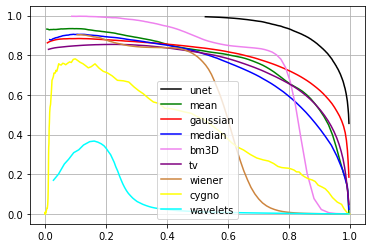

In [28]:
color = ['black', 'green', 'red', 'blue', 'violet', 'purple', 'peru', 'yellow', 'cyan']
for i in range(result_table_by_filter.shape[0]):
    row = result_table_by_filter.loc[i,:]
    x = row.recall
    y = row.precision
    fname = row['filter']
    plt.plot(x,y, label=fname, color=color[i])
plt.legend()
plt.grid()

## Determinando o ponto de operação

In [29]:
value = 0.7
output_params = {'filter':[], 'parameter':[], 'precision':[], 'recall': [], 'threshold_value': []}
for i in range(result_table_by_filter.shape[0]):
    row = result_table_by_filter.loc[i,:]
    x = row.recall
    y = row.precision
    index, precision_value = find_nearest(np.nan_to_num(y), value)
    output_params['filter'].append(row['filter'])
    output_params['parameter'].append(row.parameter)
    output_params['threshold_value'].append(row.threshold[index])
    output_params['precision'].append(precision_value)
    output_params['recall'].append(x[index])

In [30]:
pd.DataFrame(output_params)

,filter,parameter,precision,recall,threshold_value
0,unet,0,0.699102,0.970987,0.172738
1,mean,11,0.700966,0.764565,12.377007
2,gaussian,13,0.701244,0.828407,15.863791
3,median,19,0.702191,0.691158,14.144610
4,bm3D,8,0.668752,0.804553,4.178728
5,tv,0,0.701218,0.743602,12.961035
6,wiener,1,0.703599,0.545908,4.882460
7,cygno,0,0.696168,0.219816,34.184747
8,wavelets,0,0.367472,0.160743,8.225241
